In [1]:
import pandas as pd
import numpy as np

# Крок 1: Зчитування даних про енергетику з файлу
energy_df = pd.read_excel("En_In.xls", skiprows=2, usecols="C:F")
energy_df.columns = ['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable']

# Замінюємо "..." на NaN і перевіряємо наявність таких значень
energy_df['Energy Supply'] = energy_df['Energy Supply'].replace("...", np.nan)
energy_df['Energy Supply per Capital'] = energy_df['Energy Supply per Capita'].replace("...", np.nan)
energy_df['Energy Supply'] = pd.to_numeric(energy_df['Energy Supply'], errors='coerce') * 1_000_000


# Крок 3: Перейменування окремих країн
country_renames = {
    "Republic of Korea": "South Korea",
    "United States of America": "United States",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "China, Hong Kong Special Administrative Region": "Hong Kong"
}
energy_df['Country'] = energy_df['Country'].replace(country_renames)

# Крок 4: Видалення цифр та тексту в дужках із назв країн
energy_df['Country'] = energy_df['Country'].str.replace(r'\d+', '', regex=True)
energy_df['Country'] = energy_df['Country'].str.replace(r'\s*\(.*\)', '', regex=True).str.strip()

# Встановлюємо індекс за назвою країни
energy_df = energy_df.set_index('Country')[['Energy Supply', 'Energy Supply per Capita', '% Renewable']]

# Перевіряємо наявність певних країн у даних
CheckRightInfo = energy_df.loc[energy_df.index.isin(['American Samoa', 'South Korea', 'Bolivia'])]
print(CheckRightInfo)

# Крок 5: Завантаження даних про ВВП
gdp_df = pd.read_csv("gpd.csv", skiprows=4)

# Перейменування окремих країн
country_renames = {
    "Korea, Rep.": "South Korea",
    "Iran, Islamic Rep.": "Iran",
    "Hong Kong SAR, China": "Hong Kong"
}

gdp_df['Country Name'] = gdp_df['Country Name'].replace(country_renames)
gdp_df = gdp_df.rename(columns={'Country Name': 'Country'}).set_index('Country').loc[:, '2006':'2015']
print(gdp_df.head(1))

# Крок 6: Завантаження даних зі Scimagojr
scimagojr_df = pd.read_excel("scimagojr.xlsx")
scimagojr_df = scimagojr_df.loc[scimagojr_df['Rank'] <= 15]
scimagojr_df.set_index('Country', inplace=True)
scimagojr_df = scimagojr_df[['Rank', 'Documents', 'Citable documents', 'Citations', 'Self-citations', 'Citations per document', 'H index']]

# Крок 7: Об'єднання всіх DataFrame
# Об'єднуємо за країнами (використовуємо inner join)
combined_df = pd.merge(scimagojr_df, energy_df, left_index=True, right_index=True, how='inner')
combined_df = pd.merge(combined_df, gdp_df, left_index=True, right_index=True, how='inner')

# Перевірка результату
print(combined_df.head(3))


                Energy Supply Energy Supply per Capita % Renewable
Country                                                           
American Samoa            NaN                      ...    0.641026
Bolivia          3.360000e+08                       32    31.47712
South Korea      1.100700e+10                      221    2.279353
         2006  2007  2008  2009          2010  2011  2012  2013  2014  2015
Country                                                                    
Aruba     NaN   NaN   NaN   NaN  2.467704e+09   NaN   NaN   NaN   NaN   NaN
                    Rank  Documents  Citable documents  Citations  \
Country                                                             
China                  1     127050             126767     597237   
Japan                  3      30504              30287     223024   
Russian Federation     5      18534              18301      34266   

                    Self-citations  Citations per document  H index  \
Country             

In [2]:
# Завдання 8:
def calculate_average_gdp(gdp_data):
    """
    Вычисляет средний ВВП за последние 10 лет и возвращает
    топ-15 стран, отсортированных по убыванию среднего ВВП.
    Параметры:
        gdp_data (pd.DataFrame): DataFrame с данными ВВП за 10 лет.   
    Возвращает:
        pd.Series: Топ-15 стран и их средний ВВП.
    """
    gdpcolums = gdp_data.loc[:, '2006':'2015']
    
    # Вычисляем средний ВВП по строкам (странам)
    avg_gdp = gdpcolums.mean(axis=1)
    
    # Сортируем по убыванию и выбираем топ-15
    top_15_avg_gdp = avg_gdp.sort_values(ascending=False).head(15)
    
    return top_15_avg_gdp

# Вывод результата
print(calculate_average_gdp(combined_df))


Country
China                 6.348609e+12
Japan                 5.542208e+12
Germany               3.493025e+12
France                2.681725e+12
Brazil                2.189794e+12
Italy                 2.120175e+12
India                 1.769297e+12
Canada                1.660647e+12
Russian Federation    1.565459e+12
Spain                 1.418078e+12
Australia             1.164043e+12
South Korea           1.106715e+12
Iran                  4.441558e+11
dtype: float64


In [3]:
# Завдання 9:
def gdp_change_for_5th_country(gdp_data):

    # Вычисляем средний ВВП
    avg_gdp = gdp_data.mean(axis=1)
    
    # Сортируем по убыванию и находим страну с 5-м средним ВВП
    fifth_country = avg_gdp.sort_values(ascending=False).index[4]  # Индекс 4 для 5-й страны
    
    # Извлекаем значения ВВП за 2006 и 2015 год для этой страны
    gdp_2006 = gdp_data.loc[fifth_country, '2006']
    gdp_2015 = gdp_data.loc[fifth_country, '2015']
    
    # Вычисляем изменение ВВП
    gdp_change = gdp_2015 - gdp_2006
    
    return (fifth_country, gdp_change)

# Выводим результат
print(gdp_change_for_5th_country(combined_df))

('Brazil', np.float64(474343725980.5698))


In [4]:
# Завдання 10:
def country_with_max_renewable_energy(energy_data):

    # Находим страну с максимальным значением процента возобновляемой энергии
    max_renewable_country = energy_data['% Renewable'].idxmax()
    max_renewable_percentage = energy_data.loc[max_renewable_country, '% Renewable']
    
    return (max_renewable_country, max_renewable_percentage)

# Выводим результат
print(country_with_max_renewable_energy(combined_df))


('Brazil', 69.64803)


In [5]:
# Завдання 11
def population_by_energy_supply(energy_data):

    # Создаём новый столбец для оценки численности населения
    energy_data['Estimated Population'] = energy_data['Energy Supply'] / energy_data['Energy Supply per Capita']
    
    # Сортируем страны по численности населения и находим шестую страну
    sixth_country = energy_data['Estimated Population'].sort_values(ascending=False).index[5]
    
    return sixth_country

# Выводим результат
print(population_by_energy_supply(combined_df))


Germany


In [6]:
# Завдання 12
def citable_documents_per_capita_and_correlation(data):
    """
    Рассчитывает количество цитируемых документов на душу населения
    и находит корреляцию между этим показателем и энергоснабжением на душу населения.
    Параметры:
        data (pd.DataFrame): DataFrame с данными о цитируемых документах и энергоснабжении.
    Возвращает:
        float: Значение корреляции Пирсона.
    """
    # Рассчитываем количество цитируемых документов на душу населения
    data['Citable Documents per Capita'] = data['Citable documents'] / data['Estimated Population']
    
    # Рассчитываем корреляцию между количеством цитируемых документов на душу населения
    # и энергоснабжением на душу населения
    correlation = data['Citable Documents per Capita'].corr(data['Energy Supply per Capita'])
    
    return correlation

# Выводим результат
print(citable_documents_per_capita_and_correlation(combined_df))


0.8642899768854405


In [7]:
# Завдання 13
def renewable_energy_above_median(data):
    """
    Создает столбец с 1, если процент возобновляемой энергии (% Renewable) 
    равен или выше медианы, и 0, если ниже. Возвращает Series, отсортированную по Rank.  
    Параметры:
        data (pd.DataFrame): DataFrame с данными о возобновляемой энергии и рейтинге стран.  
    Возвращает:
        pd.Series: Series с 1 и 0, индексированное по странам и отсортированное по Rank.
    """
    # Вычисляем медиану по столбцу '% Renewable'
    median_renewable = data['% Renewable'].median()
    
    # Создаем новый столбец, в котором будет 1, если значение '% Renewable' выше или равно медиане, и 0 иначе
    data['Renewable Above Median'] = (data['% Renewable'] >= median_renewable).astype(int)
    
    # Сортируем по Rank и возвращаем только новый столбец в виде Series
    return data.sort_values('Rank')['Renewable Above Median']

# Выводим результат
print(renewable_energy_above_median(combined_df))


Country
China                 1
Japan                 0
Russian Federation    1
Canada                1
Germany               1
India                 0
France                0
South Korea           0
Italy                 1
Spain                 1
Iran                  0
Australia             0
Brazil                1
Name: Renewable Above Median, dtype: int64


In [8]:
def group_by_continent_and_population(data, continent_dict):
    """
    Группирует страны по континентам и вычисляет статистику для оценки количества населения.
    Параметры:
        data (pd.DataFrame): DataFrame с данными о странах и их энергетическом снабжении.
        continent_dict (dict): Словарь, который сопоставляет страны с континентами.
    Возвращает:
        pd.DataFrame: DataFrame с группировкой по континентам и статистикой по населению.
    """
    # Добавляем столбец 'Continent' на основе словаря
    data['Continent'] = data.index.map(continent_dict)
    
    # Рассчитываем оценку численности населения
    data['Population Estimate'] = data['Energy Supply'] / data['Energy Supply per Capita']
    
    # Группируем по континентам и вычисляем статистику
    continent_stats = data.groupby('Continent')['Population Estimate'].agg(
        size='size', # Кількість країн на кожному континенті
        sum='sum',  # Загальна чисельність населення
        mean='mean', # Середня чисельність населення
        std='std' # Стандартне відхилення чисельності населення
    )
    
    return continent_stats

# Словарь континентов для стран
ContinentDict = {
    'China':'Asia',
    'United States':'North America',
    'Japan':'Asia',
    'United Kingdom':'Europe',
    'Russian Federation':'Europe',
    'Canada':'North America',
    'Germany':'Europe',
    'India':'Asia',
    'France':'Europe',
    'South Korea':'Asia',
    'Italy':'Europe',
    'Spain':'Europe',
    'Iran':'Asia',
    'Australia':'Australia',
    'Brazil':'South America'
}

# Выводим результат
print(group_by_continent_and_population(combined_df, ContinentDict))


               size               sum              mean           std
Continent                                                            
Asia              5   2898666386.6106   579733277.32212  6.790979e+08
Australia         1   23316017.316017   23316017.316017           NaN
Europe            5  394058699.474436   78811739.894887  3.813228e+07
North America     1   35239864.864865   35239864.864865           NaN
South America     1  205915254.237288  205915254.237288           NaN


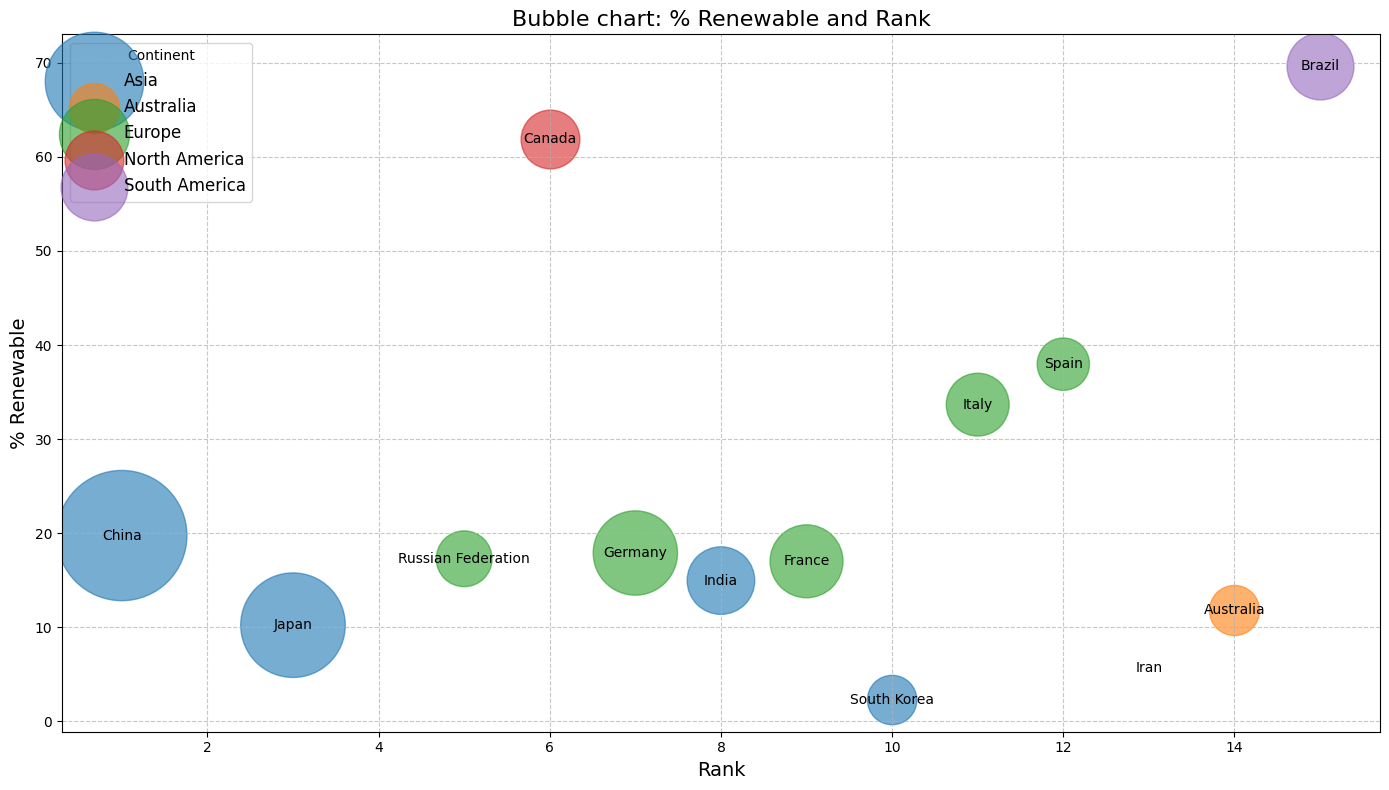

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Завдання 15: Бульбашкова діаграма
def createBubbleChart(gdp_data):
    # Перевіряємо, чи є колонка з оцінкою чисельності населення
    if 'Population Estimate' not in gdp_data.columns:
        gdp_data['Population Estimate'] = gdp_data['Energy Supply'] / gdp_data['Energy Supply per Capita']

    # Якщо континенти ще не додано до DataFrame
    if 'Continent' not in gdp_data.columns:
        ContinentDict = {
            'China': 'Asia',
            'United States': 'North America',
            'Japan': 'Asia',
            'United Kingdom': 'Europe',
            'Russian Federation': 'Europe',
            'Canada': 'North America',
            'Germany': 'Europe',
            'India': 'Asia',
            'France': 'Europe',
            'South Korea': 'Asia',
            'Italy': 'Europe',
            'Spain': 'Europe',
            'Iran': 'Asia',
            'Australia': 'Australia',
            'Brazil': 'South America'
        }
        # Додаємо континенти до DataFrame
        gdp_data['Continent'] = gdp_data.index.to_series().map(ContinentDict)

    # Перетворюємо останній рік ВВП у числовий тип
    gdp_data['2015'] = pd.to_numeric(gdp_data['2015'], errors='coerce')

    # Створюємо бульбашкову діаграму
    plt.figure(figsize=(14, 8))

    # Відображаємо дані по континентах
    for continent, group in gdp_data.groupby('Continent'):
        scatter = plt.scatter(
            group['Rank'],               # Рейтинг країни
            group['% Renewable'],        # Відсоток поновлюваних джерел
            s=group['2015'] / 1e9,      # Розмір бульбашки пропорційний ВВП
            alpha=0.6,                   # Прозорість бульбашок
            label=continent              # Мітка континенту
        )

    # Додаємо підписи країн
    for i, row in gdp_data.iterrows():
        plt.text(
            row['Rank'], 
            row['% Renewable'], 
            i,                      # Назва країни
            fontsize=10, 
            ha='center', 
            va='center', 
            color='black'
        )

    # Налаштування графіка
    plt.title('Bubble chart: % Renewable and Rank', fontsize=16)
    plt.xlabel('Rank', fontsize=14)
    plt.ylabel('% Renewable', fontsize=14)
    plt.legend(title='Continent', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Показуємо графік
    plt.tight_layout()
    plt.show()

createBubbleChart(combined_df)
